In [1]:
import warnings
warnings.filterwarnings('ignore')
import sys

sys.path.append('/data/yosef2/users/chenling/scVI/')
import scvi
scvi.__version__

import os
os.getcwd()

import logging
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from hyperopt import hp

from scvi.inference import UnsupervisedTrainer, AlternateSemiSupervisedTrainer
from scvi.models import VAE, SCANVI

from scvi.dataset.anndataset import AnnDatasetFromAnnData
import scanpy as sc
from anndata import read_h5ad
from anndata import AnnData

import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
%matplotlib inline

In [2]:
tissue = 'endopancreas'
capital_tissue = tissue[0].upper()+tissue[1:]
save_path = '../../AnnotationsRound1/data/'

In [3]:
tenx = read_h5ad(save_path + 'tabula-sapiens-10X-pilot-filtered-%s.h5ad'%tissue)

In [4]:
ss2 = read_h5ad(save_path + 'tabula-sapiens-facs-pilot-filtered-%s.h5ad'%capital_tissue)

In [5]:
save_path + 'tabula-sapiens-facs-pilot-filtered-%s.h5ad'%capital_tissue

'../../AnnotationsRound1/data/tabula-sapiens-facs-pilot-filtered-Endopancreas.h5ad'

In [6]:
adata = tenx.concatenate(ss2)

In [7]:
batch = adata.obs['10X_plate'].values.astype(str)

In [8]:
batch_names, adata.obs['batch'] = np.unique(batch,return_inverse=True)

In [9]:
data = AnnDatasetFromAnnData(adata, batch_label='batch')

[2019-12-06 14:58:22,165] INFO - scvi.dataset.anndataset | Dense size under 1Gb, casting to dense format (np.ndarray).
[2019-12-06 14:58:22,674] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2019-12-06 14:58:22,677] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2019-12-06 14:58:22,828] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2019-12-06 14:58:22,987] INFO - scvi.dataset.dataset | Downsampled from 4030 to 4030 cells


In [10]:
data.X.shape

(4030, 21301)

In [11]:
data.subsample_genes(1000)

[2019-12-06 14:58:23,113] INFO - scvi.dataset.dataset | extracting highly variable genes


Transforming to str index.


[2019-12-06 14:58:31,005] INFO - scvi.dataset.dataset | Downsampling from 21301 to 1000 genes
[2019-12-06 14:58:31,041] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2019-12-06 14:58:31,057] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2019-12-06 14:58:31,068] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2019-12-06 14:58:31,074] INFO - scvi.dataset.dataset | Downsampled from 4030 to 4030 cells


In [12]:
n_epochs = 300
save_path = '../data/'
show_plot = True
test_mode = False
use_batches = True
use_cuda = True
lr = 1e-3
retrain=False

In [13]:
data.n_batches

4

In [14]:
vae = VAE(data.nb_genes, n_batch=data.n_batches * use_batches,
          n_layers=2, n_latent=10, dispersion='gene')
trainer = UnsupervisedTrainer(
    vae,
    data,
    train_size=0.9,
    use_cuda=use_cuda,
    frequency=5,
)

In [15]:
filename = '%svae.%s10xfacs.pkl'%(save_path,tissue)
print(filename)

../data/vae.endopancreas10xfacs.pkl


In [16]:
retrain

False

In [17]:

if retrain==True:
    torch.manual_seed(0)
    trainer.train(n_epochs=n_epochs, lr=lr)
    torch.save(trainer.model.state_dict(), filename)

else:

    if os.path.isfile(filename):
        trainer.model.load_state_dict(torch.load(filename))
        trainer.model.eval()
    else:
        trainer.train(n_epochs=n_epochs, lr=lr)
        torch.save(trainer.model.state_dict(), filename)

In [18]:
trainer.train(n_epochs=n_epochs, lr=lr)

# code for plotting elbo for training and testing data

(100, 1000)

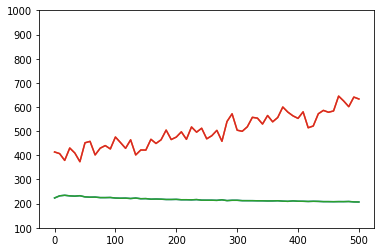

In [19]:
elbo_train_set = trainer.history["elbo_train_set"]
elbo_test_set = trainer.history["elbo_test_set"]
x = np.linspace(0, 500, (len(elbo_train_set)))
plt.plot(x, elbo_train_set)
plt.plot(x, elbo_test_set)
plt.ylim(100, 1000)

elbo_train_set = trainer.history["elbo_train_set"]
elbo_test_set = trainer.history["elbo_test_set"]
x = np.linspace(0, 500, (len(elbo_train_set)))
plt.plot(x, elbo_train_set)
plt.plot(x, elbo_test_set)
plt.ylim(100, 1000)

In [20]:
posterior = trainer.create_posterior(
        trainer.model, data, indices=np.arange(len(data))
    ).sequential()

latent, _, _ = posterior.get_latent()


# get imputed gene expression values

In [21]:
# imputed_values = posterior.sequential().imputation()
# normalized_values = posterior.sequential().get_sample_scale()

# using scVI latent space in scanpy

In [22]:
adata = tenx.concatenate(ss2)
batch = adata.obs['10X_plate'].values.astype(str)
batch_names, adata.obs['batch'] = np.unique(batch,return_inverse=True)
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [23]:
adata.obsm["X_scvi"] = latent
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=10, use_rep="X_scvi")
sc.tl.umap(adata)

sc.tl.louvain(adata, key_added="louvain_scvi", resolution=1)

In [24]:
adata.obs.columns

Index(['10X_plate', 'BA_nM', 'NovaSeqRun', 'additional_notes',
       'anatomical_position', 'barcode', 'batch', 'bead_cleanup',
       'cDNA_dilute', 'cDNA_prep_person', 'excluded', 'investigator',
       'lib_prep_date', 'library_prep', 'method', 'n_genes', 'plate',
       'primary_sort', 'sex', 'sort_direction', 'sort_order', 'subjectid',
       'tissue', 'well', 'well_group', 'louvain_scvi'],
      dtype='object')

... storing '10X_plate' as categorical
... storing 'BA_nM' as categorical
... storing 'NovaSeqRun' as categorical
... storing 'additional_notes' as categorical
... storing 'anatomical_position' as categorical
... storing 'barcode' as categorical
... storing 'bead_cleanup' as categorical
... storing 'cDNA_dilute' as categorical
... storing 'cDNA_prep_person' as categorical
... storing 'excluded' as categorical
... storing 'investigator' as categorical
... storing 'lib_prep_date' as categorical
... storing 'library_prep' as categorical
... storing 'method' as categorical
... storing 'plate' as categorical
... storing 'primary_sort' as categorical
... storing 'sex' as categorical
... storing 'sort_direction' as categorical
... storing 'sort_order' as categorical
... storing 'subjectid' as categorical
... storing 'tissue' as categorical
... storing 'well' as categorical
... storing 'well_group' as categorical


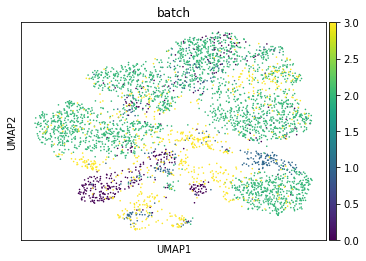

In [25]:
sc.pl.umap(adata, color=['batch'],s=10)

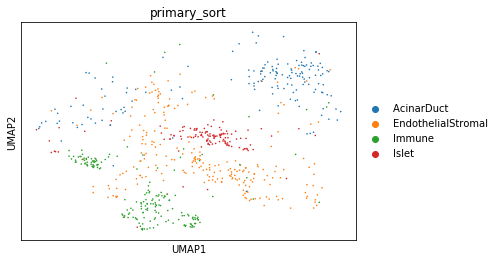

In [26]:
sc.pl.umap(adata[adata.obs['batch']==3,:], color=['primary_sort'],s=10)

# Epithilium
|Cell type | number | marker genes|
|-----|-----|-------|
|beta|0.08-0.16|INS,NKX6-1,SIX3,MAFA,OLIG1|
|alpha|0.04-0.12|GCG,DPP4,IRX1,IRX2,LOXL4|
|delta|0.01-0.06|SST,HHEX,GHSR,LEPR,POU3F1|
|epsilon|<0.001|ARX,POU6F2|
|gamma/PP|<0.002|ARX,FEV,SERTM1,CNTNAP5,PPY|

In [27]:
compartments = {'Epithelial':['EPCAM','CLDN4','CDH1'], 
                'Endothelial':['PECAM1','CLDN5','CDH5'],
                'Stromal':['COL1A2','DCN','BGN'],
               'Immune':['PTPRC','RAC2','LCP1']}

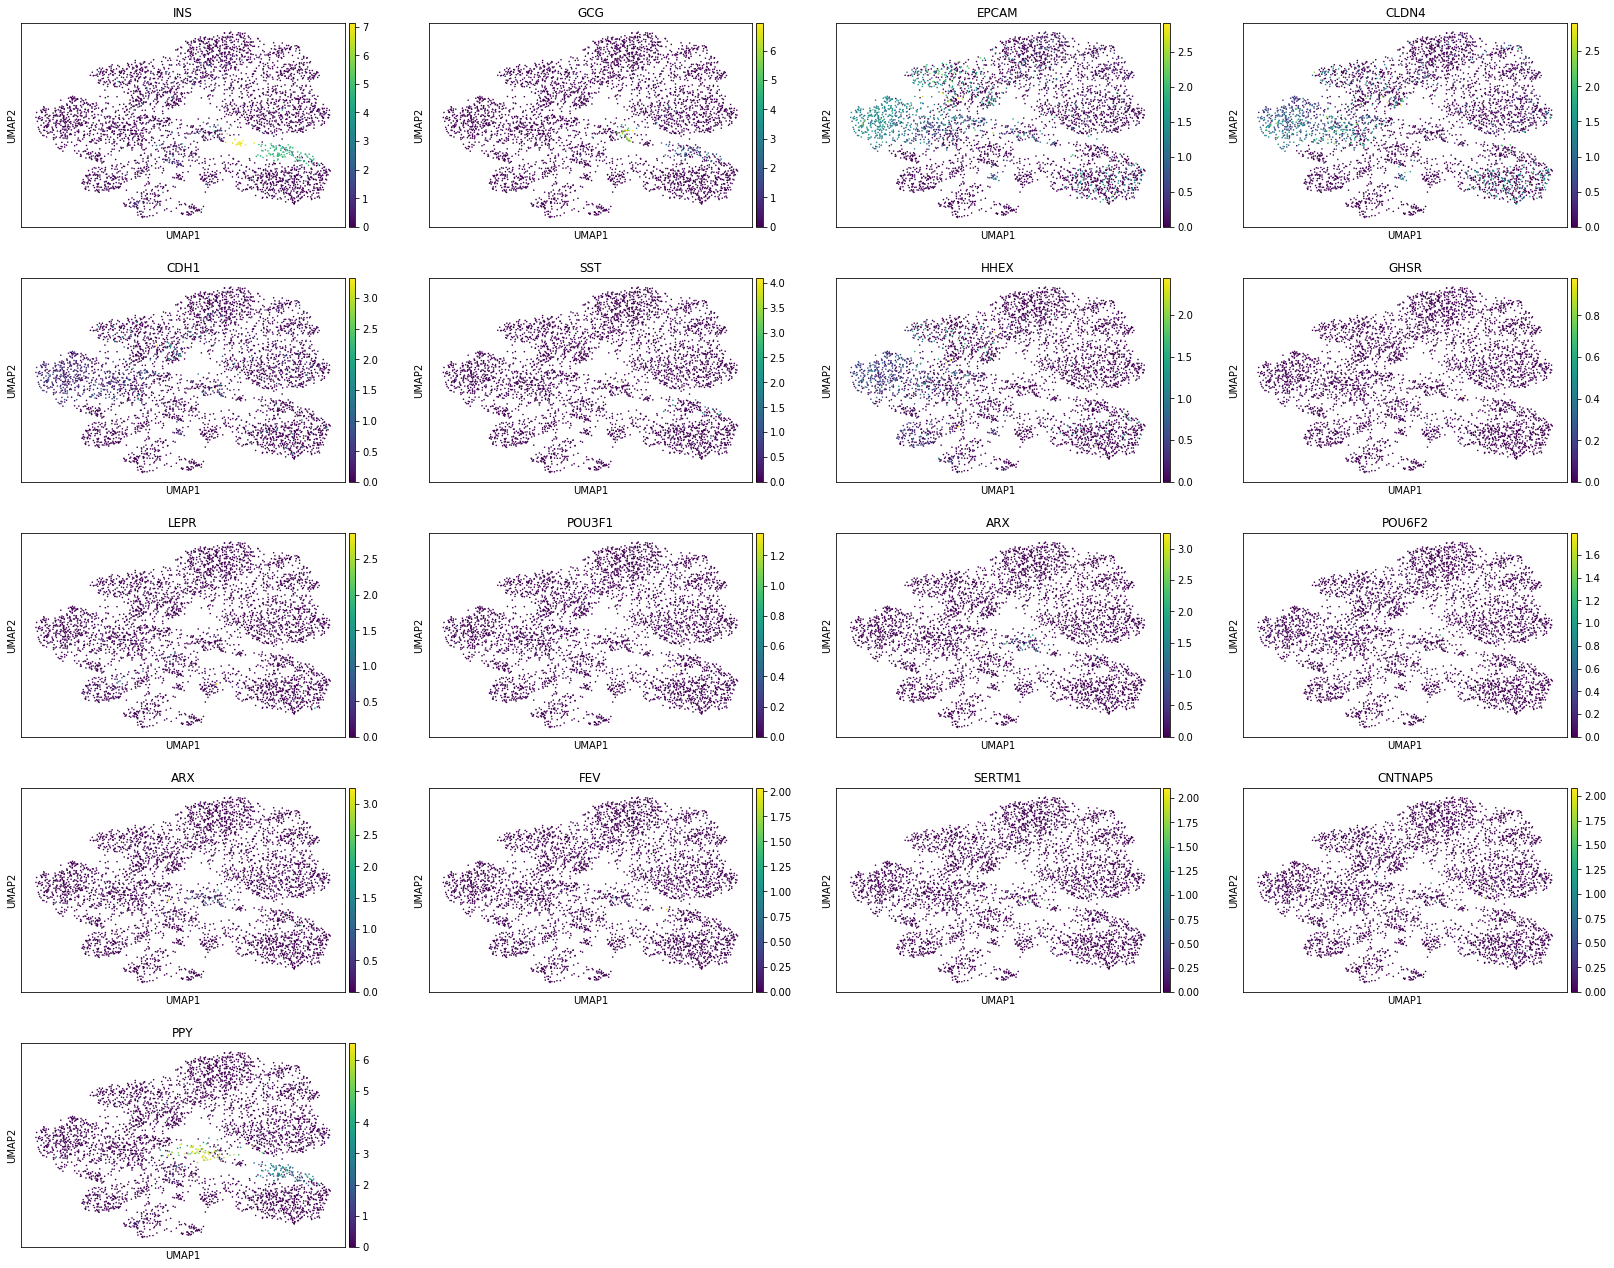

In [28]:
sc.pl.umap(adata, color=['INS','GCG' ,'EPCAM','CLDN4','CDH1',
                         'SST','HHEX','GHSR','LEPR','POU3F1',
                         'ARX','POU6F2','ARX','FEV','SERTM1','CNTNAP5','PPY'],s=10)



# Endothelium	
|Cell type | number | marker genes|
|-----|-----|-------|
|Arteriole	|	|PECAM1,PLVAP,CD40|
|Capilaries	|	|PECAM1,PLVAP|
|Venules	|	|NR2F2,VWF,VCAM1|
|Lymphatic	|	|LYVE1,MMRN1,PDPN,PROX1|

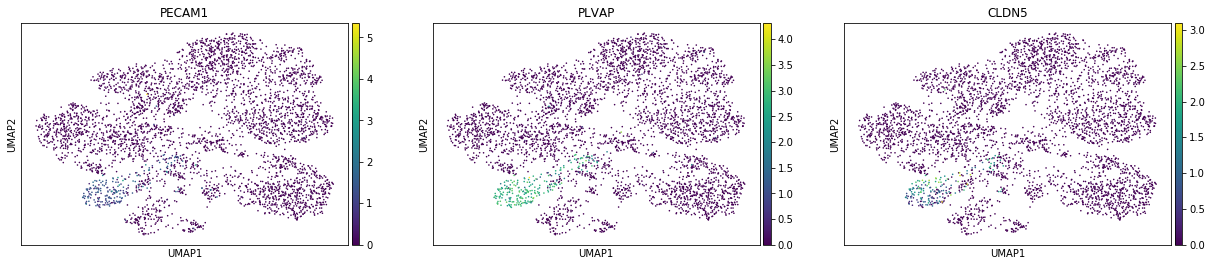

In [29]:
sc.pl.umap(adata, color=['PECAM1','PLVAP','CLDN5'],s=10)

# Stroma	
|Cell type | number | marker genes|
|-----|-----|-------|
|fibroblasts	|		|	PDGFRB,VCAN,RGS5,CSPG4,DES,PDGFRB,SPARC,COL4A1|
|Pericytes	|		|	NKX3-2,GFAP|


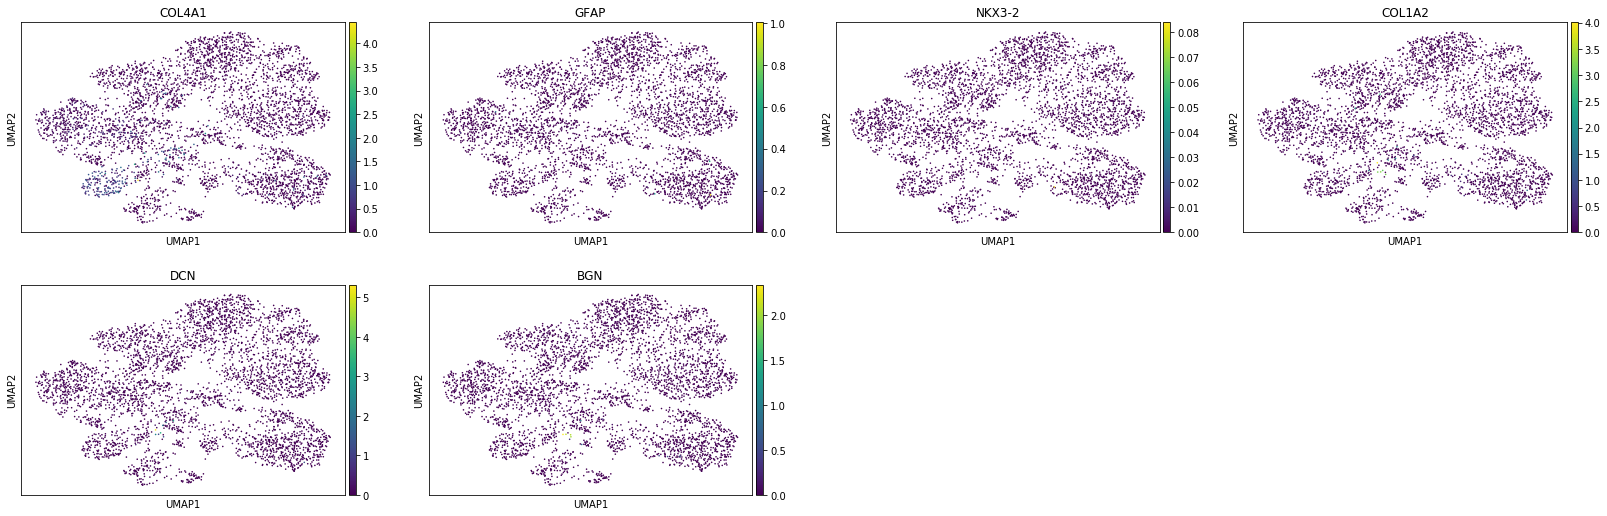

In [30]:
sc.pl.umap(adata, color=['COL4A1','GFAP','NKX3-2','COL1A2','DCN','BGN'],s=10)

# PNS
|Cell type | number | marker genes|
|-----|-----|-------|
|SchwannCells|	|SOX10,GDNF,PMP22,CRYAB,SPARC,GFAP,S100B,NCAM1|
|Neuron|	|PGP9.5,TUBB3,TH,SYN1/2,TAC2,SLC18A3|
|Sensory(afferent)|	7% of neuronal|	SP(SubstanceP)|
|Parasympathetic(ganglion,efferent)|	|VAChT(VesicularAcetylcholineTransporter)|
|Sympathetic(efferent)|	|TH(TyrosineHydroxylase)|


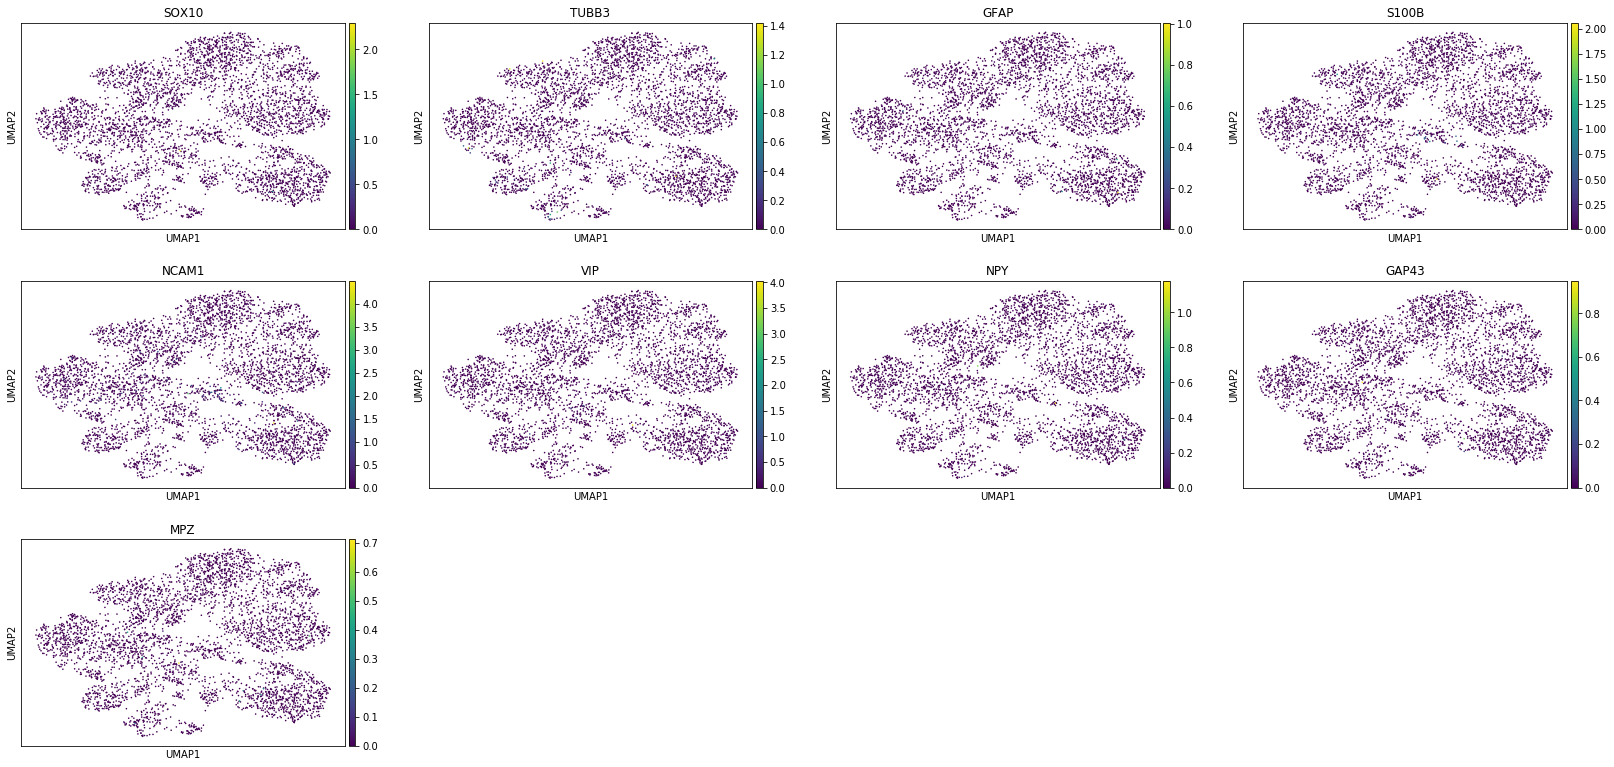

In [31]:
genelist = ['SOX10','TUBB3','GFAP','S100B','NCAM1']+['VIP' ,'NPY','GAP43','MPZ']
sc.pl.umap(adata, color=genelist,s=10)

# immune

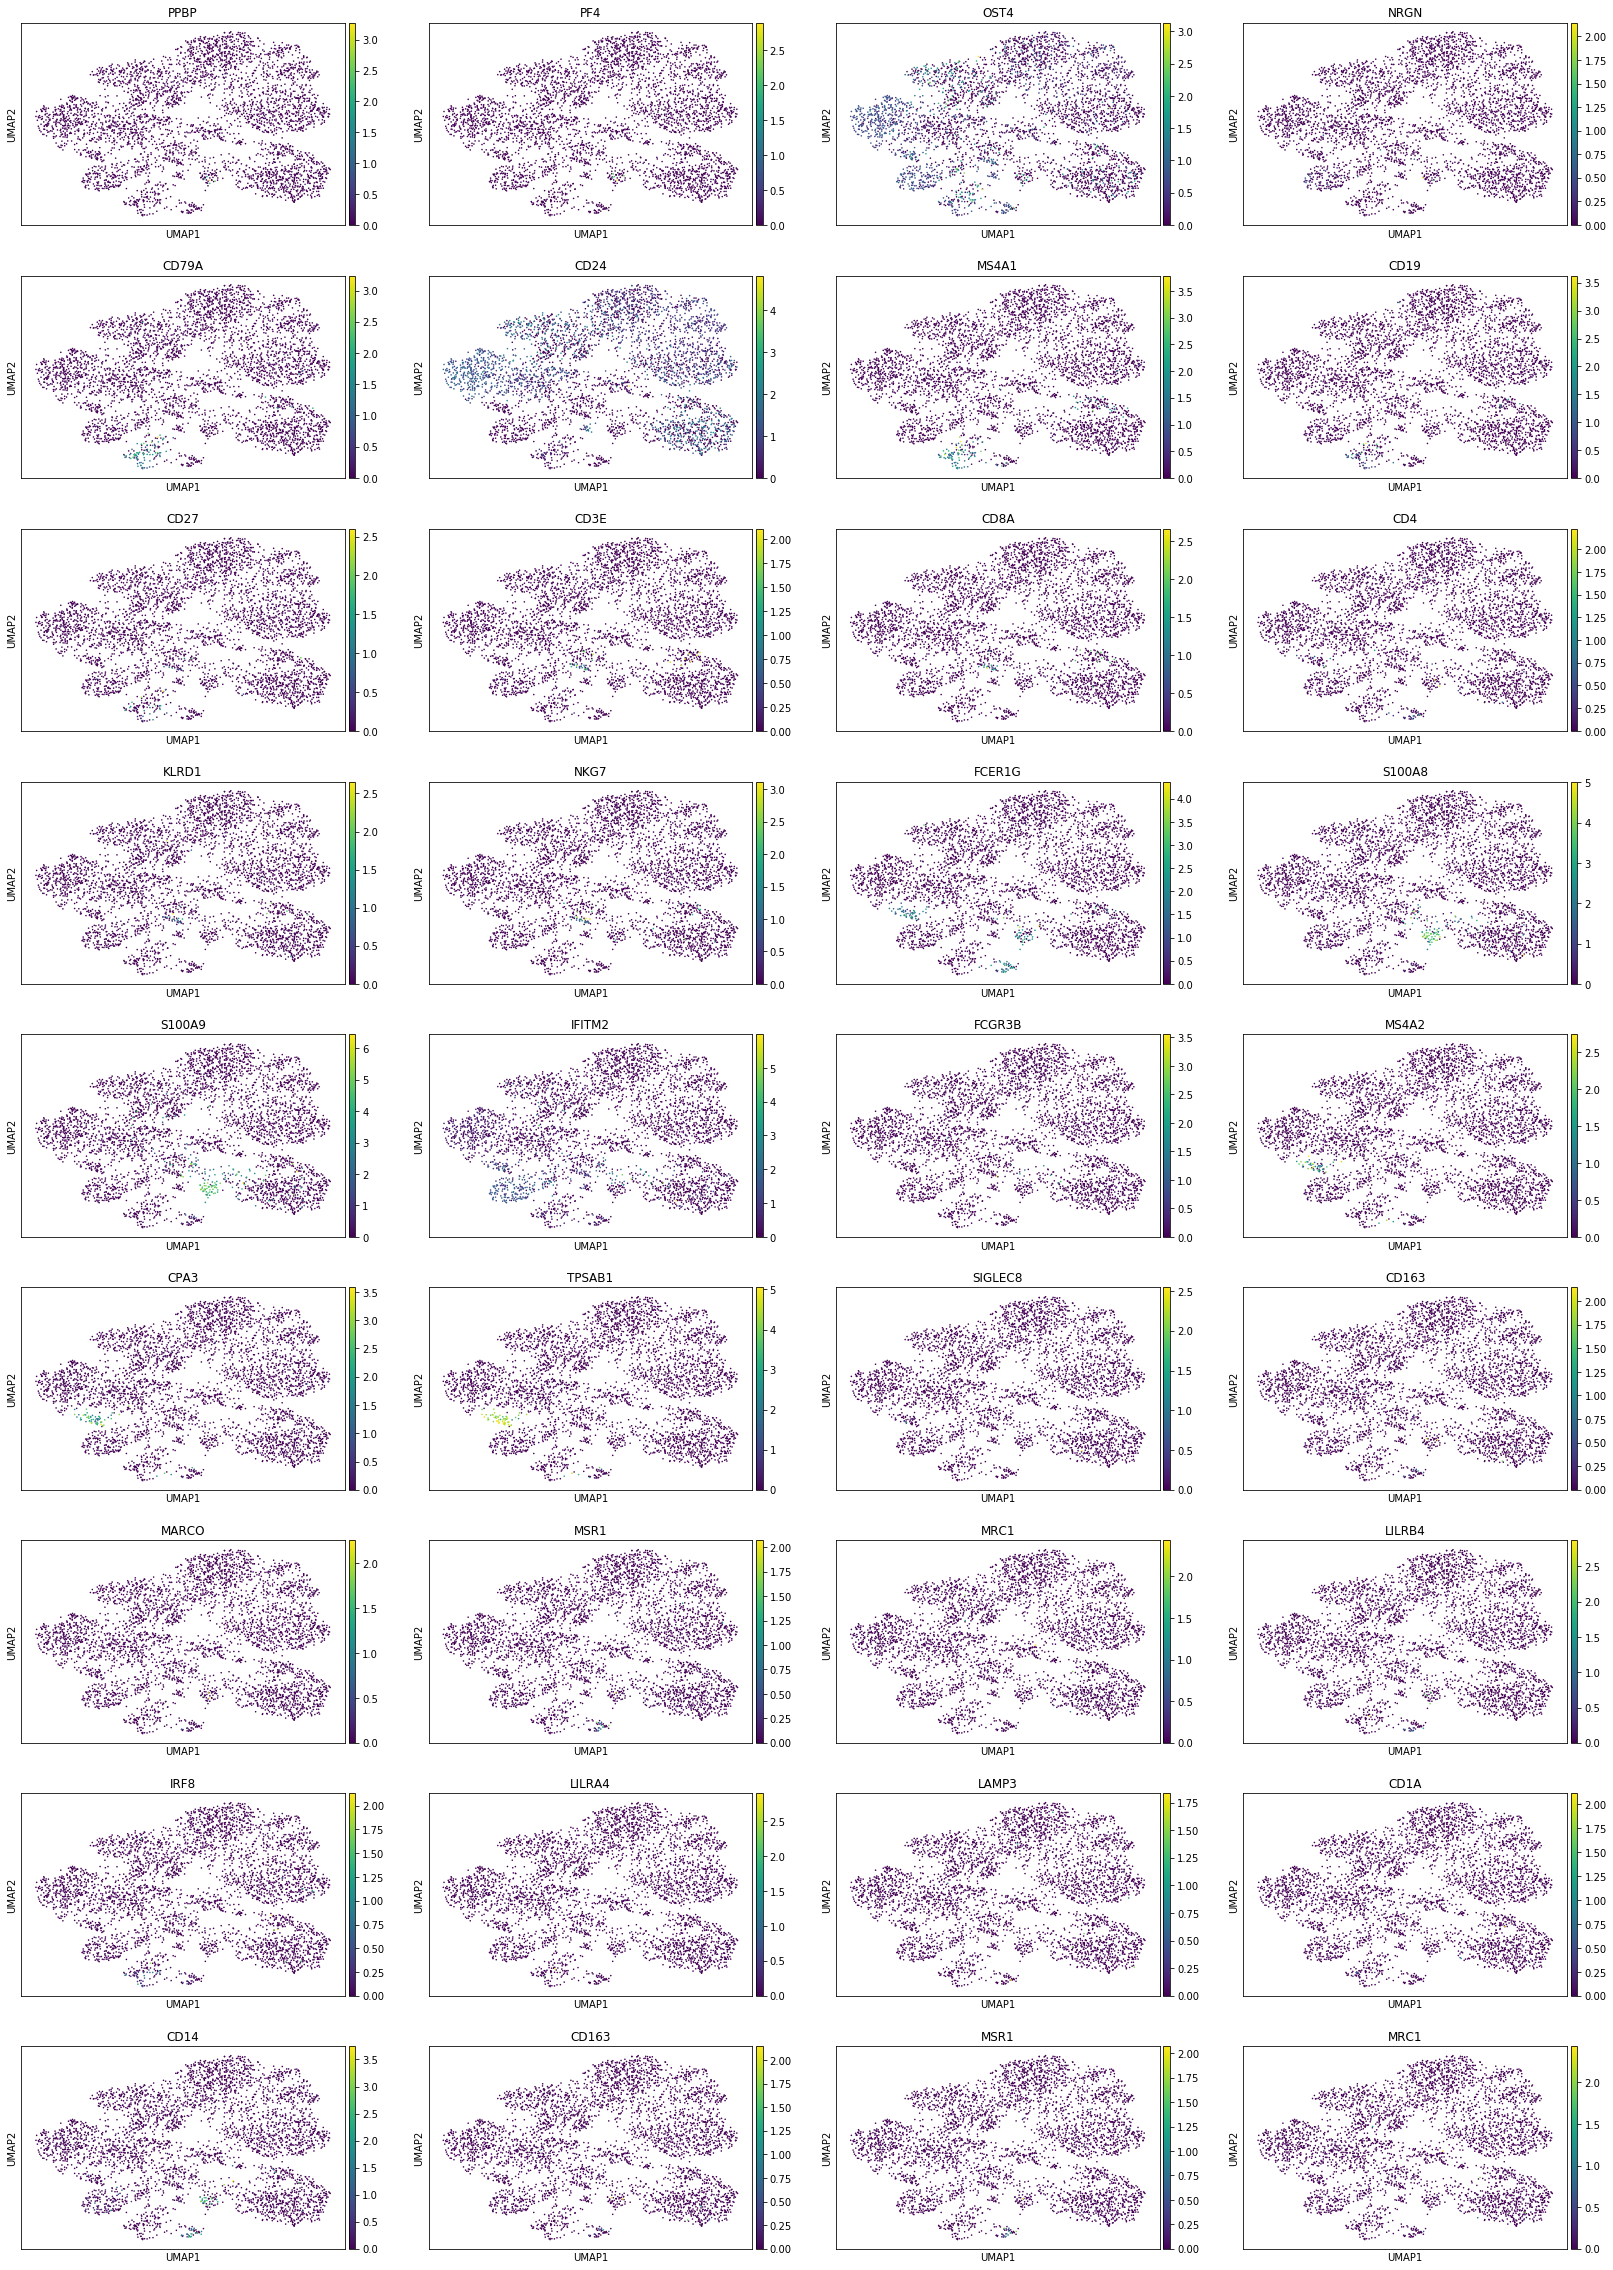

In [32]:
genelist = ['PPBP','PF4','OST4','NRGN',
            'CD79A','CD24','MS4A1','CD19',
           'CD27','CD3E','CD8A','CD4','KLRD1','NKG7','FCER1G',
           'S100A8','S100A9','IFITM2','FCGR3B',
           'MS4A2','CPA3','TPSAB1','SIGLEC8','CD163','MARCO','MSR1','MRC1',
           'LILRB4','IRF8','LILRA4','LAMP3','CD1A','CD14',
           'CD163','MSR1','MRC1']
sc.pl.umap(adata, color=genelist,s=10)

# use scANVI to split compartment, then perform leiden clustering on each compartment

In [33]:
data.cell_types, data.labels = np.unique(adata.obs['primary_sort'].values, return_inverse=True)
data.labels = data.labels.reshape(len(data.labels),1)
data.n_labels = len(data.cell_types)

In [34]:
data.cell_types

array(['AcinarDuct ', 'EndothelialStromal', 'Immune', 'Islet ', 'nan'],
      dtype=object)

In [35]:
np.unique(data.batch_indices,return_counts=True)

(array([0, 1, 2, 3], dtype=uint16), array([ 418,  319, 2571,  722]))

In [36]:
np.unique(data.batch_indices.ravel()[data.labels.ravel()==4],return_counts=True)

(array([0, 1, 2], dtype=uint16), array([ 418,  319, 2571]))

In [37]:
scanvi = SCANVI(data.nb_genes, data.n_batches, data.n_labels, n_layers=2,n_latent=10)
scanvi.load_state_dict(posterior.model.state_dict(), strict=False)
trainer_scanvi = AlternateSemiSupervisedTrainer(scanvi, data, classification_ratio=0,
                                                n_epochs_classifier=100, lr_classification=5 * 1e-3)

nan_idx = list(data.cell_types).index('nan')
islabelled = np.logical_and((data.batch_indices.ravel() == 3), data.labels.ravel()!= nan_idx )
notlabelled = np.logical_or((data.batch_indices.ravel() == 0), data.labels.ravel()== nan_idx )

labelled = np.where(islabelled)[0]
labelled = np.random.choice(labelled, len(labelled), replace=False)
trainer_scanvi.labelled_set = trainer_scanvi.create_posterior(indices=labelled)
trainer_scanvi.unlabelled_set = trainer_scanvi.create_posterior(indices=notlabelled)
trainer_scanvi.train(n_epochs=3)

full = trainer_scanvi.create_posterior(trainer_scanvi.model, data, indices=np.arange(len(data)))
_, labels_pred = full.sequential().compute_predictions()

In [38]:
np.sum(islabelled)

722

In [39]:
 data.cell_types

array(['AcinarDuct ', 'EndothelialStromal', 'Immune', 'Islet ', 'nan'],
      dtype=object)

In [40]:
adata.obs['compartment_pred'] = data.cell_types[labels_pred]

# color by predicted compartments

... storing 'compartment_pred' as categorical


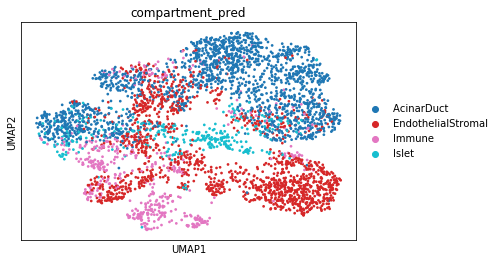

In [41]:
sc.pl.umap(adata, color=['compartment_pred'],palette = 'tab10',ncols=1)

# seed labeling with compartment markers

In [42]:
compartments = {'Epithelial':['INS','GCG' ,'EPCAM','CLDN4','CDH1'], 
                'Endothelial':['PECAM1','CLDN5','CDH5','VWF'],
                'Stromal':['ACTA2' ,'TAGLN','DCN','PDGFRA'],
               'Immune':['PTPRC','RAC2','LCP1']}

In [43]:
for x in compartments.keys():
    sc.tl.score_genes(adata, ctrl_size=100, gene_list=compartments[x],score_name = x)

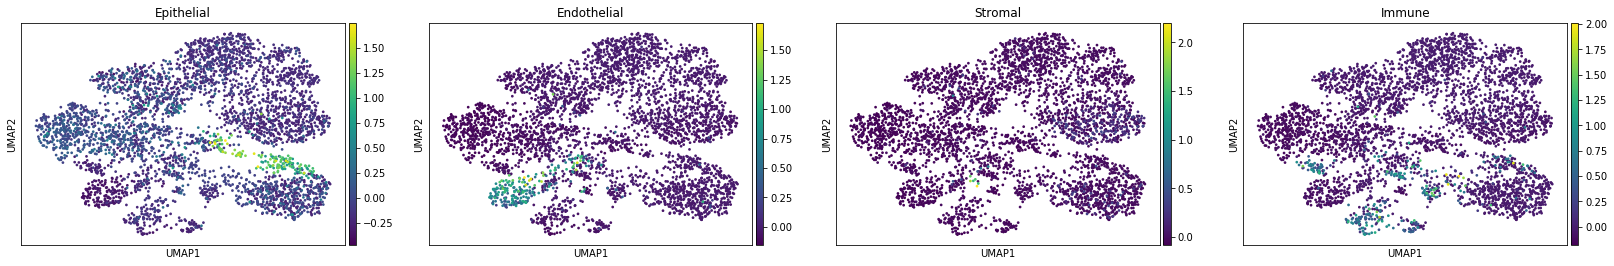

In [44]:
sc.pl.umap(adata, color=compartments.keys())

In [45]:
for x in compartments.keys():
    indicator = x+'_label'
    # compute gene signature scores
    sc.tl.score_genes(adata, compartments[x], score_name=x)
    cutoff = np.min(adata.obs.nlargest(200,x)[x].values)
    if x=='Endothelial' or x=='Stromal':
        cutoff = np.min(adata.obs.nlargest(50,x)[x].values)
    adata.obs[indicator] = (adata.obs[x].values>cutoff).astype(str)


... storing 'Epithelial_label' as categorical
... storing 'Endothelial_label' as categorical
... storing 'Stromal_label' as categorical
... storing 'Immune_label' as categorical


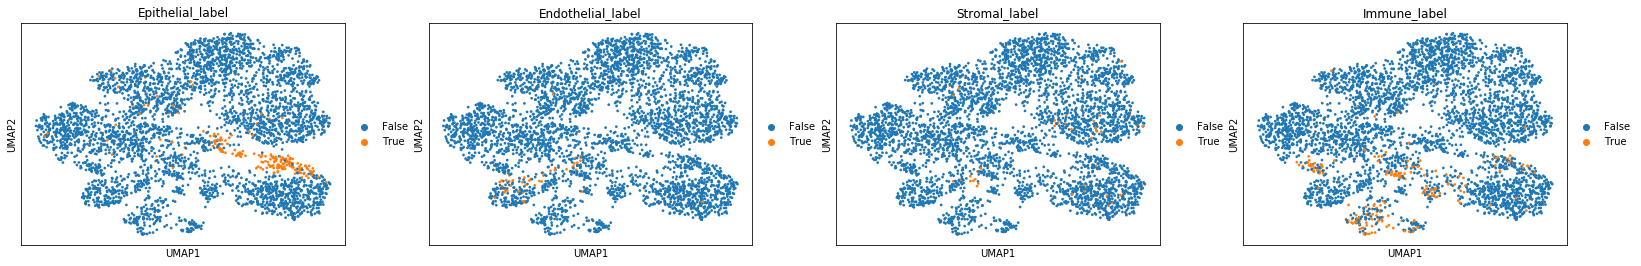

In [46]:
labelled = [x+'_label' for x in compartments.keys()]
sc.pl.umap(adata, color=labelled)

In [47]:
all_indicators = pd.concat([adata.obs[x+'_label'] for x in compartments.keys()], axis = 1)
unique_celltypes = ((all_indicators.values=='True').sum(axis=1) <=1 )

labels = np.repeat(0, data.X.shape[0])
for i, c in enumerate(compartments.keys()):
    idx = np.where(
        np.logical_and(
        unique_celltypes, 
        adata.obs[c+'_label'].values=='True'))[0]
    labels[idx] = i+1

data.cell_types = ['unlabelled']+list(compartments.keys())
data.labels = labels.reshape(len(labels),1)
data.n_labels = len(data.cell_types)

labelled = np.where(data.labels.ravel()!=0)[0]
labelled = np.random.choice(labelled, len(labelled), replace=False)

unlabelled = np.where(data.labels.ravel()==0)[0]
unlabelled = np.random.choice(unlabelled, len(unlabelled), replace=False)


In [48]:
np.unique(labels, return_counts=True)

(array([0, 1, 2, 3, 4]), array([3578,  177,   49,   48,  178]))

In [49]:

labels_pred = []
scanvi = SCANVI(data.nb_genes, data.n_batches, data.n_labels, n_layers=2,n_latent=10, symmetric_kl=True)
filename = '%s/vae.%s10xfacs.pkl'%(save_path,tissue)
scanvi.load_state_dict(torch.load(filename), strict=False)
trainer_scanvi = AlternateSemiSupervisedTrainer(scanvi, data, n_epochs_classifier=50, lr_classification=5 * 1e-3)

trainer_scanvi.labelled_set = trainer_scanvi.create_posterior(indices=labelled)
trainer_scanvi.unlabelled_set = trainer_scanvi.create_posterior(indices=unlabelled)
trainer_scanvi.train(n_epochs=15)
full = trainer_scanvi.create_posterior(trainer_scanvi.model, data, indices=np.arange(len(data)))
_, pred = full.sequential().compute_predictions()

... storing 'comp_pred' as categorical


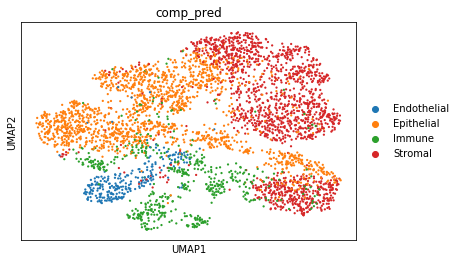

In [50]:
adata.obs['comp_pred'] = [data.cell_types[i] for i in pred]
sc.pl.umap(adata, color=['comp_pred'],  show=show_plot,size=20)

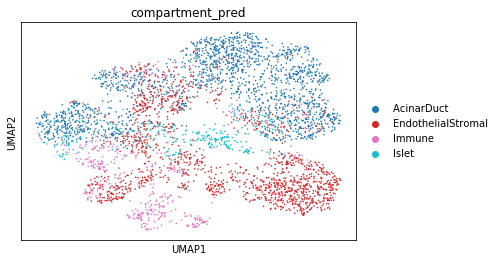

In [51]:
sc.pl.umap(adata, color=['compartment_pred'],  show=show_plot,size=10)

# plotting cell cycle changes

In [52]:
g1s_genes =  ['MCM5','PCNA','TYMS','FEN1','MCM2','MCM4','RRM1','UNG','GINS2','MCM6','CDCA7','DTL','PRIM1','UHRF1','MLF1IP','HELLS','RFC2','RPA2','NASP',
         'RAD51AP1','GMNN','WDR76','SLBP','CCNE2','UBR7','POLD3','MSH2','ATAD2','RAD51','RRM2','CDC45','CDC6','EXO1','TIPIN','DSCC1','BLM','CASP8AP2',
         'USP1','CLSPN','POLA1','CHAF1B','BRIP1','E2F8']

g2m_genes = ['HMGB2','CDK1','NUSAP1','UBE2C','BIRC5','TPX2','TOP2A','NDC80','CKS2','NUF2','CKS1B','MKI67','TMPO','CENPF','TACC3','FAM64A','SMC4','CCNB2',
        'CKAP2L','CKAP2','AURKB','BUB1','KIF11','ANP32E','TUBB4B','GTSE1','KIF20B','HJURP','HJURP','CDCA3','HN1','CDC20','TTK','CDC25C','KIF2C',
        'RANGAP1','NCAPD2','DLGAP5','CDCA2','CDCA8','ECT2','KIF23','HMMR','AURKA','PSRC1','ANLN','LBR','CKAP5','CENPE','CTCF','NEK2','G2E3','GAS2L3',
        'CBX5','CENPA']


In [53]:
sc.tl.score_genes_cell_cycle(adata, s_genes=g1s_genes, g2m_genes=g2m_genes)


... storing 'phase' as categorical


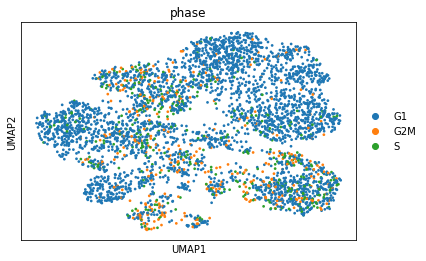

In [54]:
sc.pl.umap(adata,color=['phase'])

# differential expression

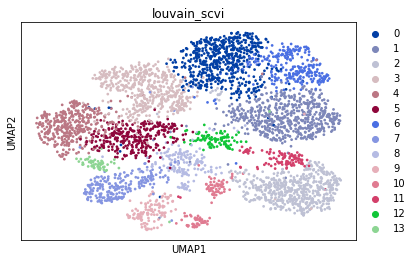

In [55]:
sc.pl.umap(adata, color=['louvain_scvi'],ncols=1)

In [ ]:
sc.tl.rank_genes_groups(
    adata,
    "louvain_scvi",
    method="wilcoxon",
    use_raw=False,
    key_added="rank_genes_groups_wilcox",
    n_genes=adata.shape[1],
)

In [ ]:
sc.pl.rank_genes_groups(
    adata, key="rank_genes_groups_wilcox", sharey=False
)

In [ ]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
result = adata.uns['rank_genes_groups_wilcox']
groups = result['names'].dtype.names
sapiens_rank_genes_scores = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'scores','pvals']})
sapiens_rank_genes_scores.to_csv('%s.wilcoxon.csv'%tissue)

In [ ]:
sapiens_rank_genes_scores

In [ ]:
adata.write('%s.scVI.h5ad'%tissue)